<h1 align="center">Contaminación Sonora</h1>

Los niveles de sonido permitidos en la ciudad de Nueva York están regulados por la Agencia de Protección Ambiental de los Estados Unidos (EPA, por sus siglas en inglés) y la Ley de Control de Ruido de la Ciudad de Nueva York.

Según la EPA, la exposición prolongada a niveles de sonido superiores a 70 decibeles (dB) puede causar daño auditivo. En Nueva York, la Ley de Control de Ruido establece que el límite máximo de ruido permitido en áreas residenciales durante el día es de 45 dB y de 42 dB durante la noche. En áreas comerciales, el límite máximo de ruido durante el día es de 85 dB y de 80 dB durante la noche.

La ciudad de Nueva York también cuenta con un programa de monitoreo de ruido en toda la ciudad, que tiene como objetivo proteger la salud y el bienestar de los residentes de la ciudad, así como reducir la contaminación acústica. El programa de monitoreo de ruido utiliza equipos de medición de sonido para medir los niveles de ruido en áreas específicas de la ciudad y se lleva a cabo en colaboración con varias agencias de la ciudad, incluida la Junta de Normas de Ruido de la Ciudad de Nueva York.

En conclusión, los niveles de sonido permitidos por el oído humano en Nueva York están regulados por la EPA y la Ley de Control de Ruido de la Ciudad de Nueva York. Los límites máximos de ruido permitidos varían según la zona y el horario del día. Además, la ciudad cuenta con un programa de monitoreo de ruido en toda la ciudad para proteger la salud y el bienestar de los residentes.

In [2]:
%load_ext autoreload
%autoreload 2
# Gestion de rutas
import utils.paths as path
# Importacion de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import requests
import os
import re

# Directorio de los datos crudos / raw data

raw_data_dir = path.make_dir_function(['datasets', 'raw'])
proc_data_dir = path.make_dir_function(['datasets', 'processed'])
inte_data_dir = path.make_dir_function(['datasets', 'interim'])
roy_data_dir = path.make_dir_function(['roy','datasets','prosseced'])

roy_data_dir = path.make_dir_function(['roy','datasets','prosseced'])
jaime_dir = path.make_dir_function(['jaime','data','finale_dataset'])

In [111]:
# Formato para el Backgound del grafico
# sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

<!-- <h2 align="center">1. Descarga de registros de presencia de tipos de sonidos en NYC</h2> -->
## 1. Descarga de registros de presencia de tipos de sonidos en NYC

In [112]:
# Funcion para descargar el dataset
def download_file(url, file_name):
    # Ruta para guardar el archivo
    file_path = raw_data_dir(raw_data_dir(), file_name)
    
    # Verifica si el archivo ya existe en la ruta especificada
    if os.path.exists(file_path):
        print(f"{file_name} ya existe en la ruta especificada.")
        return
    
    try:
        # Solicitud GET para descargar el archivo
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
            print(f"{file_name} ha sido descargado y guardado en {raw_data_dir()}")
        else:
            print(f"No se pudo descargar {file_name}. El código de estado d la solicitud es {response.status_code}.")
    except requests.exceptions.RequestException as e:
        print(f"No se pudo descargar {file_name}. Se produjo un error de red: {e}")

# URL del dataset
url = "https://zenodo.org/record/3966543/files/annotations.csv?download=1"

# Descargar el dataset
# download_file(url, 'noise_pollution.csv')

In [57]:
# Lectura del dataset
noise_pollution_v0 = pd.read_csv(raw_data_dir('noise_pollution.csv')) # Usando la librería pathlib
# noise_pollution_v0 = pd.read_sv('../../roy/datasets/prosseced/noise_pollution.csv') # Ruta directa
noise_pollution_v0.head(2)

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
0,test,0,00_026884.wav,-6,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,1,0,-1,-1,-1,-1,-1
1,test,0,00_026884.wav,-4,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1


### 1.1. Descripción general de las variables del dataset original (raw data)

**Estructuras generales de las variables del dataset original:**


* ***<coarse_id>-<fine_id>_<fine_name>_presence***

Las columnas de esta forma indican la presencia de clase de nivel fino. 1si está presente, 0si no está presente. Si -1, entonces la clase no se etiquetó en esta anotación porque la anotación la realizó un miembro del equipo de SONYC que solo anotó un grupo aproximado de clases a la vez cuando anotaba el subconjunto verificado.

* ***<coarse_id>_<coarse_name>_presence***

Las columnas de esta forma indican la presencia de una clase de nivel bajo. 1si está presente, 0si no está presente. Si -1, entonces la clase no se etiquetó en esta anotación porque la anotación la realizó un miembro del equipo de SONYC que solo anotó un grupo aproximado de clases a la vez cuando anotaba el subconjunto verificado. Estas columnas se calculan a partir de las columnas de presencia de clase de nivel fino y se presentan aquí para mayor comodidad cuando se entrena solo en clases de nivel bajo.
* ***<coarse_id>-<fine_id>_<fine_name>_proximity***

Las columnas de esta forma indican la proximidad de una clase de nivel fino. Después de indicar la presencia de una clase de nivel fino, se pidió a los anotadores de ciencia ciudadana que indicaran la proximidad del evento sonoro al sensor. Solo los voluntarios de ciencia ciudadana realizaron esta tarea, por lo que estos datos no se incluyen en las anotaciones verificadas. Esta columna puede tomar uno de los cuatro valores siguientes: ( near, far, notsure, -1). Si -1, la proximidad no se anotó porque la anotación no la realizó un voluntario de ciencia ciudadana o el voluntario de ciencia

### 1.2. Selección de variables de tipos de sonidos

Las variables que corresponden a los sonidos emitidos por los vehículos de transporte en NYC son:

1. ``1-1_small-sounding-engine_presence``: Indica si un vehículo tiene un motor de sonido pequeño o no.
2. ``1-2_medium-sounding-engine_presence``: Indica si un vehículo tiene un motor de sonido medio o no.
3. ``1-3_large-sounding-engine_presence``: Indica si un vehículo tiene un motor de sonido grande o no.
4. ``1-X_engine-of-uncertain-size_presence``: Indica si hay un motor en el vehículo cuyo tamaño de sonido no se puede determinar con certeza.
5. ``5-1_car-horn_presence``: Indica si un vehículo tiene una bocina o claxon.
6. ``5-2_car-alarm_presence``: Indica si un vehículo tiene una alarma antirrobo.
7. ``5-3_siren_presence:`` Indica si un vehículo tiene una sirena, que generalmente se asocia con vehículos de emergencia como ambulancias y patrullas.
8. ``5-4_reverse-beeper_presence``: Indica si un vehículo tiene un dispositivo de señalización de marcha atrás, que suena cuando el vehículo se mueve hacia atrás.
9. ``5-X_other-unknown-alert-signal_presence``: Indica si hay algún otro tipo de señal de alerta en el vehículo cuyo tipo no se puede determinar con certeza.

### 1.3. Renombramiento de las variables seleecionadas

In [58]:
# Variables seleccionados
selected_cols = [
    'borough',
    'block', 
    'latitude',
    'longitude',
    'year',
    'week',
    'day',
    'hour',
    '1-1_small-sounding-engine_presence',
    '1-2_medium-sounding-engine_presence',
    '1-3_large-sounding-engine_presence',
    '1-X_engine-of-uncertain-size_presence',
    '5-1_car-horn_presence',
    '5-2_car-alarm_presence',
    '5-3_siren_presence',
    '5-4_reverse-beeper_presence',
    '5-X_other-unknown-alert-signal_presence'
]
# Filtración de las avriables seleccionadas
noise_pollution_v0 = noise_pollution_v0[selected_cols]

## 2. Transformaciones del dataset original de contaminación acústica
<!-- <h2 align="center">2. Transformaciones del dataset original</h2> -->

### 2.1. Renombramiento de las variables de tipos de sonidos del dataset original

In [59]:
# Renombramiento de las columnas del dataframe
selected_sound_cols_renamed = {
'1-1_small-sounding-engine_presence': 'small_sounding_engine',
'1-2_medium-sounding-engine_presence': 'medium_sounding_engine',
'1-3_large-sounding-engine_presence': 'large_sounding_engine',
'1-X_engine-of-uncertain-size_presence': 'uncertain_size_engine',
'5-1_car-horn_presence': 'car_horn',
'5-2_car-alarm_presence': 'car_alarm',
'5-3_siren_presence': 'siren',
'5-4_reverse-beeper_presence': 'reverse_beeper',
'5-X_other-unknown-alert-signal_presence': 'unknown_alert_signal',
}
# 
noise_pollution_v1 = noise_pollution_v0.rename(selected_sound_cols_renamed, axis=1)

### 2.2. Crear una columna de fecha a partir de las variables ``year``, ``week``, ``day`` y ``hour``.

In [60]:
# Funcion para crear una columna de fecha
def make_date_col(df: pd.DataFrame, col_name: str):
    df[col_name] = pd.to_datetime(df['year'].astype(str) + df['week'].astype(str) + df['day'].astype(str), format='%Y%W%w')
    df[col_name] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['hour'].astype(str) + ':00:00')
    return df

In [61]:
# Creación de la columna date
noise_pollution_v1 = make_date_col(noise_pollution_v1, 'date')

### 2.3. Creacion de las columnas de ``borough_name`` y ``id_borough`` a partir de la columna ``borough`` del dataset original.

In [76]:
def replace_borough_by_id_borough(df: pd.DataFrame, colname: str):
    # Diccionario de los identificadores con los borough correspondientes
    borough = {
        1: 'manhattan',
        2: 'bronx',
        3: 'brooklyn',
        4: 'queens',
        5: 'staten island',
    }
    
    if colname == 'borough':
        # Generamos la variable borough_name a partir de los identificadores
        df[f'{colname}_name'] = df[colname].replace(borough)
        
        # Generamos la variable id_borough, identificador del borough
        df[f'id_{colname}'] = df[colname]
        
        # Eliminamos la columna borough del dataset original
        df = df.drop([colname], axis=1)
    
    elif colname == 'borough_name':
        # Generamos la variable id_borough_name a partir de los identificadores
        df[f'{colname}'] = df[f"id_{colname.split('_')[0]}"].replace(borough)
            
    
    return df

In [63]:
# Generando las variables id_borough y borough_name a partir del borough
noise_pollution_v1 = replace_borough_by_id_borough(noise_pollution_v1, 'borough')

### 2.4. Reemplazo de los valores ``-1`` por ``1`` en cada una de las variables de tipos de sonidos.

Despues de haber revisado [Fuente de diccionario del Dataset](https://zenodo.org/record/3966543#.ZDWBOHbMJEY) se propone el reemplazo de los valores negativos (**-1)** por el valor **1** ya que si el valor es -1, la clase no se etiquetó en esta anotación porque la anotación la realizó un miembro del equipo de SONYC que solo anotó un grupo aproximado de clases a la vez cuando anotaba el subconjunto verificado. Pero como si es un indicio de presencia de sonido (que es lo más significativo para el análisis que se plantea) reemplazaremos dicho valores por el valor 1, es decir, quedará como la clase de nivel fino presente.

In [64]:
# Funcion de itera por cada columna de los tipos de sonidos y reemplaza el -1 por 1
def replace_negatives_ones(df, cols):
    for col in cols:
        df[col] = df[col].replace(-1,1)
    return df

In [65]:
noise_pollution_v1 = replace_negatives_ones(noise_pollution_v1, 
                                            selected_sound_cols_renamed.values())

### 2.5. Agrupación de variables en dos grupos (sonidos que provienen de un motor y sonidos que provienen de una señal de alerta)

Creamos dos nuevas variables ``engine_sound_pres`` y ``alert_signal_pres`` que resumen la cantidad total de registros de sonidos provenientes del motor del vehículo y señales de alarma, respectivamente. Para la primera variable se han considerado las columnas ``'small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'`` y para la segunda ``'car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'``.

In [66]:
def summary_sound_presence(df: pd.DataFrame , cols, new_col_name:str):
    df[new_col_name] = df[cols].sum(axis=1)
    return df

In [67]:
# Sonidos de motores
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, 
                                            ['small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],
                                            'engine_sounds')
# Sonidos de señal de alerta
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, 
                                            ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'],
                                            'alert_signal_sounds'
                                            )
# Total de sonidos
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, 
                                            ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal','small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],
                                            'total_sounds')

In [68]:
# Eliminamos las columnas de los tipos de sonidos
noise_pollution_v1 = noise_pollution_v1.drop(
    ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal','small_sounding_engine', 
     'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],
    axis=1)

In [69]:
# Convertir la columna de fecha a datetime
noise_pollution_v1['date'] = pd.to_datetime(noise_pollution_v1['date'], format='%Y-%m-%d')
# Generamos la columna month correpondiente a los meses
noise_pollution_v1['month'] = noise_pollution_v1['date'].dt.month

In [70]:
# cantidad de registros de sonidos diarios
noise_pollution_v1 = noise_pollution_v1.groupby(['year','month', 'day', 'id_borough'])[['engine_sounds',	'alert_signal_sounds',	'total_sounds']].sum().reset_index()

In [71]:
# Creamos una copia del dataframe
noise_pollution_v2 = noise_pollution_v1.copy(deep=True)

In [72]:
# Creamos una copia del dataframe
noise_poll = noise_pollution_v2.copy(deep=True)
noise_poll.head()

,year,month,day,id_borough,engine_sounds,alert_signal_sounds,total_sounds
0,2016,1,0,1,15,7,22
1,2016,5,0,1,20,23,43
2,2016,5,1,1,5,3,8
3,2016,5,2,1,9,14,23
4,2016,5,3,1,4,3,7


In [77]:
# Generando las variables id_borough y borough_name a partir del borough
noise_poll = replace_borough_by_id_borough(noise_poll, 'borough_name')
noise_poll.head(2)

,year,month,day,id_borough,engine_sounds,alert_signal_sounds,total_sounds,borough_name
0,2016,1,0,1,15,7,22,manhattan
1,2016,5,0,1,20,23,43,manhattan


In [209]:
# Exportar data limpia y procesada de contaminacion acústica
export_dir = roy_data_dir('noise_pollution.parquet')
noise_poll.to_parquet(export_dir)

## 3. Volumen de tráfico vehicular

In [79]:
# Lectura del archivo
vehicle_density = pd.read_csv(jaime_dir('vehicular_volume.csv'))
vehicle_density.head(3)

,date,id_borough,borough,volume
0,2008-03-10,3,queens,169.092233
1,2008-03-10,5,staten_island,399.421053
2,2008-03-11,3,queens,124.629902


In [80]:
# Lectura del dataset Volumen vehicular
vehicle_density['year'] = pd.to_datetime(vehicle_density['date']).dt.year

In [81]:
# Filtro de fecha del 2016 al 2019
vehicle_density = vehicle_density[(vehicle_density['year'] <= 2019) & (vehicle_density['year'] >= 2016)]

In [82]:
# Conversion de la métrica del volumen vehicular en días
vehicle_density[['volume']] = (vehicle_density.loc[::,['volume']])*(4*24)

In [86]:
# Resetear el index
vehicle_density = vehicle_density.reset_index(drop=True)

### 4. Unión de los dataframes

In [87]:
vehicle_density.head(1)

,date,id_borough,borough,volume,year
0,2016-01-04,2,brooklyn,8312.350598,2016


In [88]:
noise_poll.head(1)

,year,month,day,id_borough,engine_sounds,alert_signal_sounds,total_sounds,borough_name
0,2016,1,0,1,15,7,22,manhattan


In [149]:
# Union de los datasets a través del identificador de borough
data_v0 = pd.merge(vehicle_density[['date','id_borough','volume']], noise_poll, left_on='id_borough',right_on='id_borough')

In [150]:
data_v0.head(1)

,date,id_borough,volume,year,month,day,engine_sounds,alert_signal_sounds,total_sounds,borough_name
0,2016-01-04,1,10507.035933,2016,1,0,15,7,22,manhattan


In [151]:
# Eliminando la columna id_borough
data_v0 = data_v0.drop('id_borough', axis=1)
# Convertir la columna de fecha a datetime
data_v0['date'] = pd.to_datetime(data_v0['date'], format='%Y-%m-%d')

* Análisis de la correlacion de las variables de volumen vehicular, cantidad de sonidos procedentes de motores y cantidad de sonidos procedentes señales de alerta

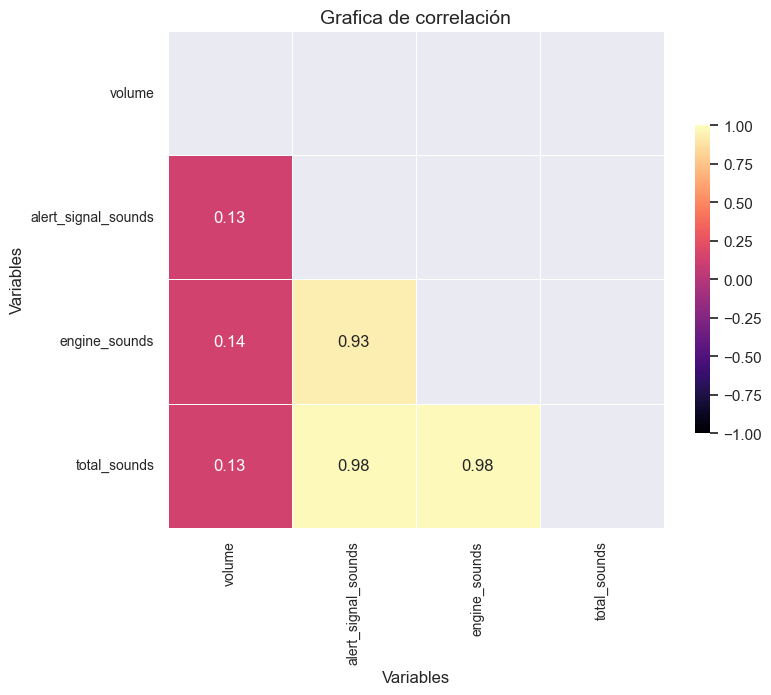

In [152]:
sns.set_theme(style = 'darkgrid')

corr_matrix = data_v0[['volume','alert_signal_sounds','engine_sounds', 'total_sounds']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

fig, ax = plt.subplots(figsize = (8, 8))

sns.heatmap(corr_matrix, mask = mask, cmap = 'magma', vmax = 1,vmin = -1, center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5}, annot=True)

# Añadir etiquetas a los ejes
ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("Variables", fontsize=12)

# Personalizar los tickets en ambos ejes
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Añadir título a la figura
ax.set_title("Grafica de correlación", fontsize=14)

plt.show()

* Se observa una correlación alta entre las variables ``engine_sound_pres`` y ``alert_signal_pres``, lo que implica que la presencia de un sonido proveniente de un motor de un vehículo está relacionado con la presencia de un sonido cuyo fuente es una señal de alerta.
* Además, parece que la variable ``engine_sound_pres`` (el número de registros de sonidos de motores) mantiene mayor correlación con el ``volume`` (volumen de tráfico) que ``alert_signal_pres`` y ``total_sounds_pres``, la correlacion es muy cercano a 0.1

## 5. KPI: Medición del ratio de sonidos registrados por volumen de tráfico diriamente

Definiremos dos métricas:
1. **rat_soundeng_voltraf**: Ratio sonidos registrados de motores por volumen de tráfico diariamente.
2. **rat_alertsig_voltraf**: Ratio sonidos registrados de señales de alerta por volumen de tráfico diariamente.

Mientras mayor sea el **rat_soundeng_voltraf** y **rat_alertsig_voltraf** implica que a mayor cantidad de vehículos que transitan en un día, se registran mayor cantidad de sonidos que provienen de los motores o señales de alerta, respectivamente. El objetivo de implementar un flota vehicular que mitigue el problema de la contaminación acústica es reducir los ratios mencionados, de tal forma que tengamos un gran volumen de automovil transitando al día y se reduzcan la presencia de sonidos provenientes de motores y señales de alerta.

Variables que consideraremos para estudiar la contaminación acústica:

* volume: Cantidad de vehículos que transitan por un día (24 horas).
* alert_signal_pres: Cantidad de registro de sonidos provenientes del motor de un vehículo por día
* engine_sound_pres: Cantidad de registro de sonidos provenientes del señales de alarma por día

In [153]:
# Suma de registros diarios totales
data_v0 = data_v0.groupby(['borough_name','date']).sum()

In [154]:
# Reseteamos el index
data_v0 = data_v0.reset_index()
data_v0

,borough_name,date,volume,year,month,day,engine_sounds,alert_signal_sounds,total_sounds
0,brooklyn,2016-01-04,1.133819e+06,435882,1449,651,2888,3518,6406
1,brooklyn,2016-01-05,8.889120e+05,435882,1449,651,2888,3518,6406
2,brooklyn,2016-01-06,9.042624e+05,435882,1449,651,2888,3518,6406
3,brooklyn,2016-01-07,1.880822e+06,435882,1449,651,2888,3518,6406
4,brooklyn,2016-01-08,2.207333e+06,435882,1449,651,2888,3518,6406
...,...,...,...,...,...,...,...,...,...
2701,queens,2019-12-06,4.512000e+03,32299,103,52,199,237,436
2702,queens,2019-12-07,2.224000e+03,32299,103,52,199,237,436
2703,queens,2019-12-08,5.280000e+02,32299,103,52,199,237,436
2704,queens,2019-12-09,3.840000e+03,32299,103,52,199,237,436


In [155]:
# Calculo del ratio sonidos registrados de motores por volumen de tráfico diariamente
data_v0['rat_soundeng_voltraf'] = data_v0['engine_sounds'] / data_v0['volume']
# Cálculo del ratio sonidos registrados de señales de alerta por volumen de tráfico diariamente.
data_v0['rat_alertsig_voltraf'] = data_v0['alert_signal_sounds'] / data_v0['volume']
# Cálculo del ratio total de sonidos registrados por volumen de tráfico diariamente.
data_v0['rat_totalsoun_voltraf'] = data_v0['total_sounds'] / data_v0['volume']

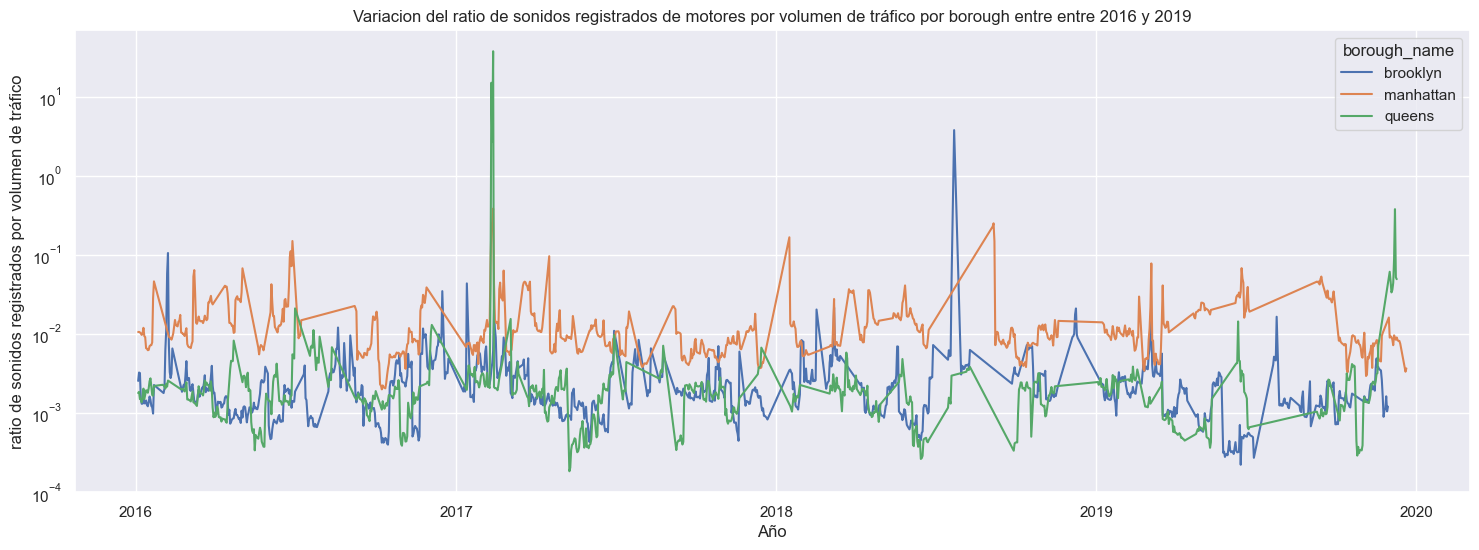

In [156]:
# Seleccionar las columnas relevantes del dataframe
rat_cols = ['rat_soundeng_voltraf', 'rat_alertsig_voltraf','rat_totalsoun_voltraf', 'borough_name', 'date']

# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
g = sns.lineplot(data=data_v0[rat_cols], x='date', y='rat_soundeng_voltraf', hue='borough_name')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variacion del ratio de sonidos registrados de motores por volumen de tráfico por borough entre entre {data_v0['date'].dt.year.min()} y {data_v0['date'].dt.year.max()}")
g.set(yscale="log")

# Etiquetas de ejes
plt.xlabel('Año')
plt.ylabel('ratio de sonidos registrados por volumen de tráfico')

plt.show()

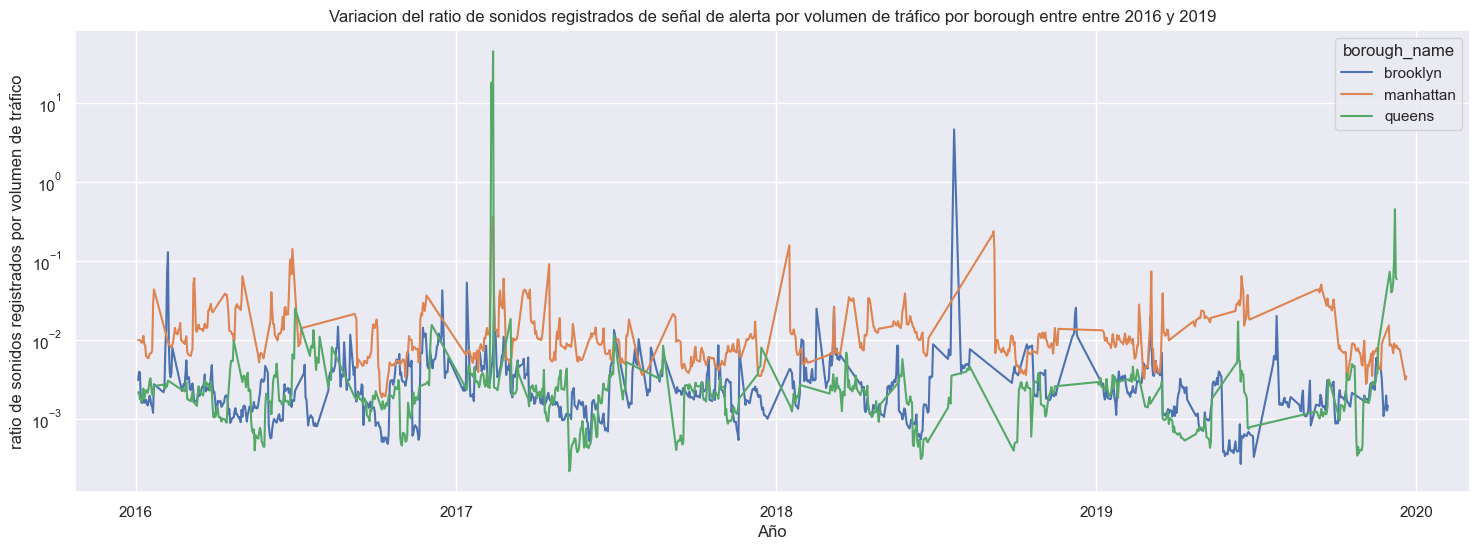

In [157]:
# Seleccionar las columnas relevantes del dataframe
rat_cols = ['rat_soundeng_voltraf', 'rat_alertsig_voltraf','rat_totalsoun_voltraf', 'borough_name', 'date']

# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
g = sns.lineplot(data=data_v0[rat_cols], x='date', y='rat_alertsig_voltraf', hue='borough_name')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variacion del ratio de sonidos registrados de señal de alerta por volumen de tráfico por borough entre entre {data_v0['date'].dt.year.min()} y {data_v0['date'].dt.year.max()}")
g.set(yscale="log")
# Etiquetas de ejes
plt.xlabel('Año')
plt.ylabel('ratio de sonidos registrados por volumen de tráfico')

plt.show()

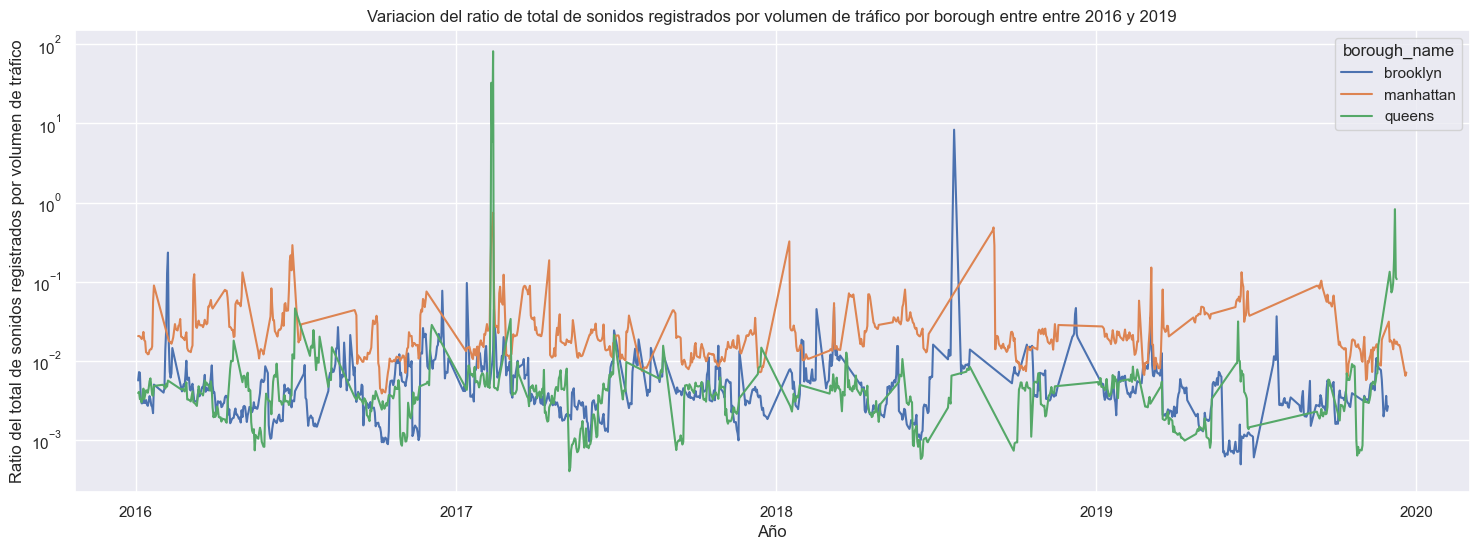

In [158]:
# Seleccionar las columnas relevantes del dataframe
rat_cols = ['rat_soundeng_voltraf', 'rat_alertsig_voltraf','rat_totalsoun_voltraf', 'borough_name', 'date']

# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
g = sns.lineplot(data=data_v0[rat_cols], x='date', y='rat_totalsoun_voltraf', hue='borough_name')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variacion del ratio de total de sonidos registrados por volumen de tráfico por borough entre entre {data_v0['date'].dt.year.min()} y {data_v0['date'].dt.year.max()}")
g.set(yscale="log")

# Etiquetas de ejes
plt.xlabel('Año')
plt.ylabel('Ratio del total de sonidos registrados por volumen de tráfico')

plt.show()

### 4.1. Cálculo del decremento porcentual de sonidos registrados despues de eliminar los provenientes de motores, es decir, despues de implementar vehículos eléctricos.

In [ ]:
# avg_rat_soundeng_voltraf = data_v0['rat_soundeng_voltraf'].mean()
data_v0['year'] = data_v0['date'].dt.year

In [178]:
data_v1 = data_v0.copy(deep=True)
data_v1['year'] = data_v1['date'].dt.year

In [179]:
# Cantidad de registros de sonidos y volumen de tráfico promedio cada año
data_v1 = data_v1.groupby(['borough_name','year']).mean()


In [180]:
# Calculo del ratio sonidos registrados de motores por volumen de tráfico diariamente
data_v1['rat_soundeng_voltraf'] = data_v1['engine_sounds'] / data_v1['volume']
# Cálculo del ratio sonidos registrados de señales de alerta por volumen de tráfico diariamente.
data_v1['rat_alertsig_voltraf'] = data_v1['alert_signal_sounds'] / data_v1['volume']
# Cálculo del ratio total de sonidos registrados por volumen de tráfico diariamente.
data_v1['rat_totalsoun_voltraf'] = data_v1['total_sounds'] / data_v1['volume']

In [181]:
# Reseteo del index
data_v1 = data_v1.reset_index()

In [212]:
def kpi_noise_pollution_reduction(data, electric_vehs, borough):
    df = data[data['borough_name'] == borough]
    
    avg_total_sounds = df['total_sounds'].mean()
    avg_rat_engsounds = df['rat_totalsoun_voltraf'].mean()
    reducction_count = (avg_total_sounds - avg_rat_engsounds * electric_vehs)
    reducction_pct = 100 - ( reducction_count / avg_total_sounds ) * 100
    # return reducction_pct
    return {
            'electr_vehicle': electric_vehs,
            'reducction_count': reducction_count.round(),
            'reducction_pct' : reducction_pct.round(2),
            }

In [213]:
kpi_noise_pollution_reduction(data_v1, 1300000,'manhattan')

{'electr_vehicle': 1300000,
 'reducction_count': 37168.0,
 'reducction_pct': 37.41}